<a href="https://colab.research.google.com/github/HoarfrostRaven/Apprentissages-Automatiques-Appliques/blob/main/IMDB_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB数据集的二分类情感分析

大纲如下：
- [Model](#Model-Part)
- [DataLoader](#DataLoader-Part)
- [Train_loop & Test_loop](#Train_loop-Part)
- [Controller](#Controller-Part)
- <span style='font-weight: bold; font-size: 1.2em; color:green;'>[Console](#Console-Part)</span>
- [Evaluater](#Evaluater-Part)

导入需要使用的`Python package`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable, List
from pathlib import Path
import torch.optim as optim
import math
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## `Model` Part

### Tranformer
- `TransformerBlock`实现Transformer架构的核心编码器块，包含自注意力机制和前馈神经网络。该模块使用残差连接、层归一化和dropout来提高模型性能和稳定性。

   `nn.MultiheadAttention`:对于每一个$\text{head}_{i}$, 从`Input`出发，经过矩阵乘法得到$Q_{i},K_{i},V_{i}$，并对他们使用注意力机制，得到单个头的输出，再用$W^{O}$整合所有头的输出，得到我们最终的`Output`，其中$W^{Q}_{i}, W^{K}_{i}, W^{V}_{i}, W^{O}$是可训练的网络参数：
   $$Q_{i}, K_{i}, V_{i} = W^{Q}_{i} \times \text{Input}, \quad W^{K}_{i} \times \text{Input}, \quad W^{V}_{i} \times \text{Input}$$  
   $$\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_{1}, \cdots, \text{head}_{h})W^{O}$$
   $$\text{head}_{i} = \text{Attention}(Q_{i}, K_{i}, V_{i})$$
   $$\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^{T}}{\sqrt{d_{k}}})V$$  
   `forward`: 多头注意力的输出经过残差连接和层归一化：
   $$X_{\text{norm}} = \text{LayerNorm}(\text{Input} + \text{MultiHead}(Q, K, V))$$  
   然后，通过前馈神经网络（FFN）处理：
   $$\text{FFN}(X) = \text{ReLU}(X \cdot W_1 + b_1) \cdot W_2 + b_2$$  
   最后，再次应用残差连接和层归一化：
   $$\text{Output} = \text{LayerNorm}(X_{\text{norm}} + \text{FFN}(X_{\text{norm}}))$$

- `TokenAndPositionEmbedding`:Token和位置嵌入模块, 将输入token索引转换为密集向量表示，并添加位置编码信息。位置编码使模型能够理解序列中token的相对位置。

- `Transformer`: 基于Transformer的文本分类模型，此模型实现了为文本分类任务设计的简化版Transformer架构。

In [2]:
class TransformerBlock(nn.Module):
    """
    Transformer Block

    参数:
        embed_dim (int): 输入特征的维度
        num_heads (int): 注意力头的数量
        ff_dim (int): 前馈网络中的隐藏维度
        rate (float, optional): Dropout率(默认为0.1)

    输入:
        inputs (torch.Tensor): 形状为[batch_size, sequence_length, embed_dim]的输入张量

    输出:
        torch.Tensor: 与输入形状相同的转换后的特征
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ff_dim: int,
        rate: float = 0.1,
    ):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=num_heads, batch_first=True
        )

        self.dense_1 = nn.Linear(embed_dim, ff_dim)
        self.dense_2 = nn.Linear(ff_dim, embed_dim)

        self.layer_norm_1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layer_norm_2 = nn.LayerNorm(embed_dim, eps=1e-6)

        self.dropout_1 = nn.Dropout(rate)
        self.dropout_2 = nn.Dropout(rate)

    def forward(self, inputs):
        attn_output, _ = self.attention(inputs, inputs, inputs)
        attn_output = self.dropout_1(attn_output)
        out1 = self.layer_norm_1(inputs + attn_output)

        ffn_output = self.dense_1(out1)
        ffn_output = F.relu(ffn_output)
        ffn_output = self.dense_2(ffn_output)
        ffn_output = self.dropout_2(ffn_output)

        return self.layer_norm_2(out1 + ffn_output)

In [3]:
class TokenAndPositionEmbedding(nn.Module):
    """

    参数:
        max_length (int): 支持的最大序列长度
        vocab_size (int): 词汇表大小
        embed_dim (int): 嵌入向量的维度

    输入:
        x (torch.Tensor): 形状为[batch_size, sequence_length]的整数数组(Token索引)

    输出:
        torch.Tensor: 形状为[batch_size, sequence_length, embed_dim]的嵌入向量
    """

    def __init__(self, max_length: int, vocab_size: int, embed_dim: int):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)

        ## 可学习的位置编码
        # self.pos_emb = nn.Embedding(max_length, embed_dim)

        ## 原论文中的位置编码
        pe = torch.zeros(max_length, embed_dim).cuda()
        positions = torch.arange(0, max_length, device=pe.device).unsqueeze(1)
        div_term = (1 / (10000**(torch.arange(0, embed_dim, 2).float() / embed_dim))).cuda()
        pe[:, 0::2] = torch.sin(positions * div_term)
        pe[:, 1::2] = torch.cos(positions * div_term)

        self.register_buffer("positional_encoding", pe)


    def forward(self, x):
        ## 可学习的位置编码
        # positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        # return self.token_emb(x) + self.pos_emb(positions)

        ## 原论文中的位置编码
        maxlen = x.size(-1)
        x = self.token_emb(x)
        pos_enc = self.positional_encoding[:maxlen,:].unsqueeze(0)
        return x + pos_enc

In [4]:
class Transformer(nn.Module):
    """
    参数:
        embed_dim (int): token嵌入的维度大小
        num_heads (int): 注意力头的数量
        ff_dim (int): 前馈网络中的隐藏层大小
        num_block(int): Transformer Block的数量
        maxlen (int): 最大输入序列长度
        vocab_size (int): 词汇表大小

    输入:
        x (torch.Tensor): 形状为[batch_size, sequence_length]的整数数组(Token索引)

    输出:
        torch.Tensor: 形状为[batch_size, 2]的浮点数组(两个类别的概率分布)
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ff_dim: int,
        num_blocks:int,
        maxlen: int,
        vocab_size: int,
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_blocks)
        ])
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.Linear(embed_dim, 20)
        self.dropout2 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.embedding_layer(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = torch.mean(x, dim=1)
        x = self.dropout1(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        x = F.softmax(x, dim=-1)
        return x

### LSTM

- `nn.LSTM`: 应用一个多层的长短期记忆网络（LSTM）到输入序列中。对于输入序列中的每一个元素，每一层执行以下计算：
  $$
  \begin{aligned}
   i_t &= \sigma(W_{\text{ii}}x_t + b_{\text{ii}} + W_{\text{hi}}h_{t-1} + b_{\text{hi}}) \\
   f_t &= \sigma(W_{\text{if}}x_t + b_{\text{if}} + W_{\text{hf}}h_{t-1} + b_{\text{hf}}) \\
   g_t &= \tanh(W_{\text{ig}}x_t + b_{\text{ig}} + W_{\text{hg}}h_{t-1} + b_{\text{hg}}) \\
   o_t &= \sigma(W_{\text{io}}x_t + b_{\text{io}} + W_{\text{ho}}h_{t-1} + b_{\text{ho}}) \\
   \color{orange}{c_t} \, &\color{orange}{=f_t \odot c_{t-1} + i_t \odot g_t} \\
   h_t &= o_t \odot \tanh(c_t)
   \end{aligned}
   $$
   其中：
   - $h_t$ 表示时间步 $t$ 的隐藏状态；
   - $c_t$ 表示时间步 $t$ 的神经元状态（cell state）；
   - $x_t$ 是时间步 $t$ 的输入；
   - $h_{t-1}$ 是前一个时间步的隐藏状态，或者是初始的隐藏状态（当 $t = 0$ 时）；
   - $i_t, f_t, g_t, o_t$ 分别是输入门、遗忘门、候选状态、输出门；
   - $\sigma$ 是 sigmoid 激活函数；
   - $\odot$ 表示 Hadamard（元素乘）运算。

- `LSTM`: 由一个`lstm`网络和一个全连接网络`FNN`组成

   `forward`:
   $$
   \begin{aligned}
   \text{output}, \text{cell} = \text{lstm}(\text{input}) \\
   \text{probs} = \text{Softmax}(\text{FNN}())
   \end{aligned}
   $$

In [5]:
class LSTM(nn.Module):
    def __init__(self,
                vocab_size : int,
                embedding_dim : int,
                hidden_dim : int,
                n_layers:int = 1,
                dropout:float = 0.2):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            batch_first=True,
                            dropout=dropout if n_layers > 1 else 0
                            )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 2) # 二分类问题

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        _, (hidden_t, _) = self.lstm(embedded)
        logits = self.fc(self.dropout(hidden_t[-1, :, :]))
        probs = F.softmax(logits, dim=-1)
        return probs

## `DataLoader` Part

- `IMDBDataset`：我们实现了`Pytorch`抽象类`Dataset`的一个子类，用于我们文本分类的任务。（所有`Dataset`子类必须要实现`__getitem__`方法，可选择实现`__len__`方法用于返回数据集的大小）

`prepare_data_loader`: 准备训练和验证的数据加载器的函数。此函数加载数据集，将其分为训练集和验证集，并创建相应的数据加载器。数据加载过程使用`PyTorch`的`DataLoader`进行并行处理，以提高数据加载效率。工作流程：  
- 从指定路径加载数据集
- 根据给定比例将数据集分为训练集和验证集
- 为训练集和验证集创建`Dataset`对象
- 配置数据加载器，设置批量大小、工作进程数等

返回一个包含训练和验证数据集的字典（{"train": `train_loader`, "test": `test_loader`}）

In [6]:
class IMDBDataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def __getitem__(self, idx):
        return {
            "encoded_indices": torch.tensor(self._x[idx], dtype=torch.long),
            "label": torch.tensor(self._y[idx], dtype=torch.long),
        }

    def __len__(self):
        return len(self._x)

In [7]:
def prepare_data_loader(
    path: str,
    ratio: float = 0.2,
    batch_size: int = 128,
    seed: int = 12,
    num_workers: int = 4,
) -> dict:
    """
    参数:
        path (str): .npz格式的数据集文件路径
        ratio (float, optional): 用于验证的数据比例(默认为0.2)
        batch_size (int, optional): 训练批量大小(默认为128)
        seed (int, optional): 用于随机打乱的种子(默认为12)
        num_workers (int, optional): 数据加载的工作进程数(默认为4)

    返回:
        dict: 包含训练和测试数据加载器的字典
    """
    train_data = np.load(path)

    x_data = train_data["X"]
    y_data = train_data["y"]

    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data,
        test_size=ratio,         # 20% 的数据作为验证集
        random_state=seed,         # 固定随机种子，保证结果可复现
        stratify=y_data          # 按标签比例划分，确保验证集和训练集标签分布一致
    )

    train_batch_size = batch_size
    test_batch_size = train_batch_size

    # 创建PyTorch数据集
    train_dataset = IMDBDataset(x_train, y_train)
    test_dataset = IMDBDataset(x_test, y_test)

    # 创建数据加载器
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return {"train": train_loader, "test": test_loader}

## `Train_loop` Part
这一部分是实现神经网络在一个训练周期中的两个关键步骤：
- 在训练集上面计算损失，并依据损失更新参数
- 在测试集上面计算度量(Metric)，跟踪当前参数下的泛化性能

我们实现了`train_step`和`eval_step`两个函数分别执行单步(step)的训练步骤和测试步骤，`train_per_epoch`和`test_per_epoch`两个函数分别执行一个回合(epoch)的训练步骤和测试步骤。对于深度学习而言，一个`step`包含对一批(`batch`)数据的处理，一个`epoch`包含多个`step`，当把数据集的数据都训练过一遍，我们称为一个`epoch`，也就是说当数据集能被`batch`整除的时候，有:
$$ \text{batch\_sizes} * \text{num\_steps} = \text{total\_data} $$

`train_per_epoch` : 此函数处理一个完整`epoch`的训练过程:
- 设置模型为训练模式
- 遍历训练数据加载器中的所有批次
- 对每个批次执行前向和后向传播并使用优化器更新模型参数
- 使用进度条跟踪和显示训练指标

`test_per_epoch` : 此函数处理一个完整`epoch`训练后的评估过程:
- 设置模型为评估模式
- 遍历测试数据加载器中的所有批次
- 在不更新梯度的情况下计算前向传播
- 计算评估指标（损失、准确率等），记录并显示评估结果


In [8]:
def train_step(
    model: nn.Module,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    batch: dict,
    device: torch.device
):
    """
    参数:
        model (nn.Module): 要训练的模型
        loss_fn (Callable): 损失函数
        optimizer (optim.Optimizer): 用于更新模型参数的优化器
        batch (dict): 包含训练数据的批次
        device (torch.device): 用于计算的设备(gpu or cpu)
    返回:
        float: 当前批次的损失值
    """
    model.train()
    optimizer.zero_grad()

    batch_tokens = batch["encoded_indices"].to(device)
    labels = batch["label"].to(device)

    loss = loss_fn(model(batch_tokens), labels)

    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
def eval_step(model: nn.Module, metric_fn: Callable, batch: dict, device: torch.device):
    """
    参数:
        model (nn.Module): 用于测试的模型
        metric_fn (Callable): 测试集上的度量函数
        batch (dict): 测试数据的批次
        device (torch.device): 用于计算的设备(gpu or cpu)

    返回:
        tuple: (loss, logits, labels) - 损失值、预测结果和真实标签
    """

    model.eval()
    with torch.no_grad():
        batch_tokens = batch["encoded_indices"].to(device)
        labels = batch["label"].to(device)
        logits = model(batch_tokens)
        metric = metric_fn(logits, labels)

        return metric.item(), logits, labels

In [10]:
def train_per_epoch(
    model: nn.Module,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    batch_size: int,
    train_loader: DataLoader,
    device: torch.device,
):
    """
    参数:
        model (nn.Module): 训练模型
        optimizer (optim.Optimizer): 用于更新模型参数的优化器
        train_loader (DataLoader): 包含训练数据的DataLoader
        device (torch.device): 用于计算的设备
    """
    model.train()
    length = len(train_loader.dataset)
    for batch_idx, batch in enumerate(train_loader):
        loss = train_step(model, loss_fn, optimizer, batch, device)
        if batch_idx % 20 == 0:
            current = batch_idx * batch_size + len(batch["encoded_indices"])
            print(f" Loss: {loss:>6.4f}, {current:>5d}/{length:>5d}")

In [11]:
def test_per_epoch(
    model: nn.Module,
    metric_fn: Callable,
    test_loader: DataLoader,
    device: torch.device,
):
    """
    参数:
        model (nn.Module): 测试模型
        test_loader (DataLoader): 包含测试数据的DataLoader
        device (torch.device): 用于计算的设备
    """
    model.eval()

    total_loss = 0.0
    correct = 0

    num_batches = len(test_loader)
    num_data = len(test_loader.dataset)
    with torch.no_grad():
        for batch in test_loader:
            loss, logits, labels = eval_step(model, metric_fn, batch, device)
            total_loss += loss
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / num_batches
    accuracy = correct / num_data
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    return avg_loss, accuracy

## `Controller` Part
这一部分是我们这份代码的控制中枢，我们实例化上文已经写好的类，调用上文已经写好的各个函数，组合起来实现我们的IMDB数据集的情感分析任务。在这一部分，我们要指定需要设定的绝大部分超参数，开展训练并得到我们训练好的模型。

In [12]:
def plot_metrics(
    losses: List[float],
    accuracies: List[float]
) -> None:
    """
    接受每个 epoch 的损失和准确率列表，绘制两条曲线。
    """
    epochs = list(range(1, len(losses) + 1))
    plt.figure(figsize=(12, 5))

    # Avg Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses)
    plt.title("Test Avg Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Avg Loss")

    # Accuracy 曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [a * 100 for a in accuracies])
    plt.title("Test Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()

In [13]:
def controller(seed: int,
               model_type: str,
               embed_dim: int,
               num_heads: int,
               ff_dim: int,
               num_blocks:int,
               lstm_embed: int,
               hidden_dim: int,
               ratio: float,
               batch_size: int,
               epochs: int,
               learning_rate: float):
    torch.manual_seed(seed)
    data_path = Path("processed_imdb_train_data.npz")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 模型初始化
    if model_type == "Transformer":
        model = Transformer(
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_blocks=num_blocks,
            maxlen=200,
            vocab_size=20000,
        ).to(device)
    elif model_type == "LSTM":
        model = LSTM(
            vocab_size=20000,
            embedding_dim=lstm_embed,
            hidden_dim=hidden_dim,
        ).to(device)
    else:
        raise ValueError("Invalid model type")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()
    metric_fn = nn.CrossEntropyLoss()

    loader_dict = prepare_data_loader(data_path, ratio, batch_size, seed)
    train_loader = loader_dict["train"]
    test_loader = loader_dict["test"]

    # 用于保存每个 epoch 的测试指标
    test_losses: List[float] = []
    test_accuracies: List[float] = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}\n" + "-"*30)
        train_per_epoch(model, loss_fn, optimizer, batch_size, train_loader, device)

        # 固定学习率 vs 动态学习率
        # scheduler.step() # 每个epoch结束时更新学习率

        loss_epoch, acc_epoch = test_per_epoch(model, metric_fn, test_loader, device)
        test_losses.append(loss_epoch)
        test_accuracies.append(acc_epoch)

    print("Training complete!")
    plot_metrics(test_losses, test_accuracies)
    return model

## `Console` Part
这个板块是我们的总控制台，在这里我们设定所有的超参数，调用我们前面写好的所有类和函数，训练模型并返回我们的模型


Epoch 1/50
------------------------------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 Loss: 0.6925,   128/32000
 Loss: 0.6906,  2688/32000
 Loss: 0.6916,  5248/32000
 Loss: 0.6928,  7808/32000
 Loss: 0.6924, 10368/32000
 Loss: 0.6917, 12928/32000
 Loss: 0.6939, 15488/32000
 Loss: 0.6907, 18048/32000
 Loss: 0.6949, 20608/32000
 Loss: 0.6912, 23168/32000
 Loss: 0.6883, 25728/32000
 Loss: 0.6927, 28288/32000
 Loss: 0.6934, 30848/32000
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693368 


Epoch 2/50
------------------------------
 Loss: 0.6944,   128/32000
 Loss: 0.6959,  2688/32000
 Loss: 0.6962,  5248/32000
 Loss: 0.6912,  7808/32000
 Loss: 0.6889, 10368/32000
 Loss: 0.6912, 12928/32000
 Loss: 0.6883, 15488/32000
 Loss: 0.6947, 18048/32000
 Loss: 0.6934, 20608/32000
 Loss: 0.6951, 23168/32000
 Loss: 0.6971, 25728/32000
 Loss: 0.6922, 28288/32000
 Loss: 0.6911, 30848/32000
Test Error: 
 Accuracy: 50.3%, Avg loss: 0.693049 


Epoch 3/50
------------------------------
 Loss: 0.6901,   128/32000
 Loss: 0.6912,  2688/32000
 Loss: 0.6879,  5248/32000
 Loss: 0.6902,  7808/32000


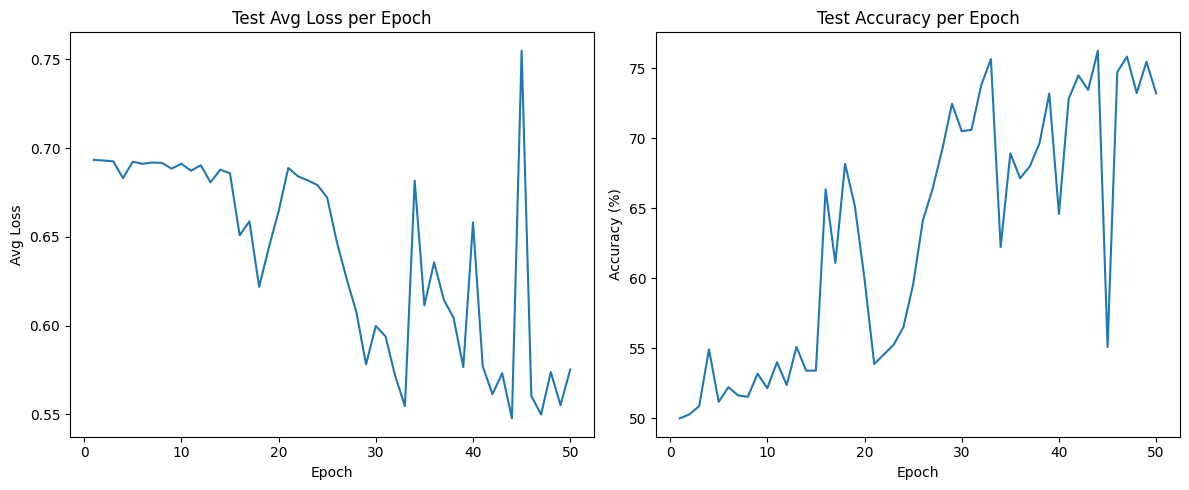

In [14]:
seed = 12 # 设置我们的全局随机种子

model_type = "LSTM" # 指定要选择的模型["Transformer", "LSTM"]
# Transformer模型相关的超参数, 如果是LSTM则不需要关注
# embed_dim 必须能整除 num_heads，否则无法分头
embed_dim = 32
num_heads = 2
ff_dim = 32
num_blocks = 2

# LSTM模型相关的超参数
lstm_embed = 32
hidden_dim = 32

ratio = 0.2 #测试集占数据集的比例
batch_size = 128 # batch的大小
epochs = 50 # 训练回合数
learning_rate = 5e-4 #初始学习率的大小


model = controller(seed,
                   model_type,
                   embed_dim,
                   num_heads,
                   ff_dim,
                   num_blocks,
                   lstm_embed,
                   hidden_dim,
                   ratio,
                   batch_size,
                   epochs,
                   learning_rate)

## `Evaluater` Part

<div class="alert alert-block alert-warning">
<b>这部分代码同学们不用修改调参，不会影响我们训练模型的性能。
</div>

这一部分我们调用已经训练好的模型，去预测我们`kaggle`给出的不带标签(`label`)的测试数据集，并将我们预测的结果写成一个`submission.csv`文件，放在指定的`kaggle`云文件夹下，便于自动评估我们提交模型的表现。

In [17]:
def evaluater(model: nn.Module):
    model.eval()
    test_data_path = Path("processed_imdb_test_data.npz")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        test_data = np.load(test_data_path)
        test_tokens = test_data["X"]  # shape: (num_samples, 200)
        test_labels = test_data["y"]  # shape: (num_samples,)

        all_preds = []

        batch_size = 500
        num_batches = int(np.ceil(len(test_tokens) / batch_size))

        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, len(test_tokens))
            batch_test_tokens = torch.tensor(test_tokens[start:end], dtype=torch.long).to(device)

            logits = model(batch_test_tokens)
            _, batch_predicted_labels = torch.max(logits, dim=-1)
            all_preds.append(batch_predicted_labels.cpu().numpy())

        # 拼接所有预测结果
        predicted_labels = np.concatenate(all_preds)
        # 计算准确率
        accuracy = accuracy_score(test_labels, predicted_labels)
        print(f"测试集准确率：{accuracy * 100:.2f}%")

In [18]:
evaluater(model)

测试集准确率：72.75%
